In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score

from utils import load_embedded_data

In [2]:
X_train, y_train, X_test, y_test = load_embedded_data(split_train=True, split_test=False)
X_train, y_train, X_test_split, y_test_split = load_embedded_data(split_train=True, split_test=True)

X_train shape: (10, 5000, 1000)
y_train shape: (10, 5000, 1)
X_test shape: (10000, 1000)
y_test shape: (10000, 1)
X_train shape: (10, 5000, 1000)
y_train shape: (10, 5000, 1)
X_test shape: (10, 1000, 1000)
y_test shape: (10, 1000, 1)


In [3]:
lf = pickle.load(open("output/lf_task_10_small.p", "rb"))

In [10]:
# Get task conditional probabilities.
for t in range(10):
    print("Testing task:", t)
    task_cond_probs_t = lf.predict_proba(X_test, t)

    if t == 0:
        task_cond_probs = task_cond_probs_t
    else:
        task_cond_probs = np.concatenate((task_cond_probs, task_cond_probs_t), axis=1)

pickle.dump(task_cond_probs, open("output/task_cond_probs_small.p", "wb"))

Testing task: 0
Testing task: 1
Testing task: 2
Testing task: 3
Testing task: 4
Testing task: 5
Testing task: 6
Testing task: 7
Testing task: 8
Testing task: 9


In [11]:
task_cond_probs = pickle.load(open("output/task_cond_probs_small.p", "rb"))

# Should be n_test = 10*1000 by 10*10 = 100
print("Task conditional probs shape:", task_cond_probs.shape)

Task conditional probs shape: (10000, 100)


In [15]:
# Within task accuracy.
task_aware_acc = []
for t in range(10):
    print("TASK", t)
    print("----------------")
    
    data_start, data_end = t * 1000, (t+1) * 1000
    classes_start, classes_end = t * 10, (t+1) * 10
    
    posterior = task_cond_probs[data_start : data_end, classes_start : classes_end]
    y_pred = np.argmax(posterior, axis = 1)
    y_true = np.mod(y_test_split[t], 10)
    acc = accuracy_score(y_true, y_pred)
    task_aware_acc.append(acc)
    print("Test accuracy: ", acc)
pickle.dump(np.mean(task_aware_acc), open("output/task_aware_acc_small.p", "wb"))

TASK 0
----------------
Test accuracy:  0.802
TASK 1
----------------
Test accuracy:  0.752
TASK 2
----------------
Test accuracy:  0.769
TASK 3
----------------
Test accuracy:  0.757
TASK 4
----------------
Test accuracy:  0.737
TASK 5
----------------
Test accuracy:  0.686
TASK 6
----------------
Test accuracy:  0.625
TASK 7
----------------
Test accuracy:  0.735
TASK 8
----------------
Test accuracy:  0.761
TASK 9
----------------
Test accuracy:  0.8


In [16]:
y_pred = np.argmax(task_cond_probs, axis = 1)

unweighted_acc = accuracy_score(y_test, y_pred)

pickle.dump(unweighted_acc, open("output/unweighted_acc_small.p", "wb"))

print("Accuracy of argmax_{y, t} p(y | x, t):", unweighted_acc)

Accuracy of argmax_{y, t} p(y | x, t): 0.2414


In [17]:
priors = pickle.load(open("output/task_priors_small.p", "rb"))

# Should be 10*n by 10 (num_tasks), where n is the number of points per task (1000) 
print("priors shape:", priors.shape)
print("task_cond_probs shape:", task_cond_probs.shape)
print("y_test shape:", y_test.shape)

priors shape: (10000, 10)
task_cond_probs shape: (10000, 100)
y_test shape: (10000, 1)


In [18]:
prior_pred = np.argmax(priors, axis=1)
X_train, t_train, X_test, t_test = load_embedded_data(task_prior=True)

print(priors.shape)
print(np.unique(t_test))

prior_pred_acc = accuracy_score(prior_pred, t_test)
print("Accuracy of argmax_{t} p(t | x):", prior_pred_acc)

X_train shape: (50000, 1000)
y_train shape: (50000, 1)
X_test shape: (10000, 1000)
y_test shape: (10000, 1)
(10000, 10)
[0 1 2 3 4 5 6 7 8 9]
Accuracy of argmax_{t} p(t | x): 0.478


In [19]:
n_test = 10000
n_classes = 100

posterior = np.zeros((n_test, n_classes))
prior_pred = np.argmax(priors, axis=1)

for i in range(n_test):
    for j in range(n_classes):
        posterior[i, j] = task_cond_probs[i, j] * priors[i, j // 10]

In [20]:
y_pred_weighted = np.argmax(posterior, axis=1)

weighted_acc = accuracy_score(y_test, y_pred_weighted)

pickle.dump(weighted_acc, open("output/weighted_acc_small.p", "wb"))

print("Accuracy of argmax_y sum_t p(y | x, t) p(t | x):", weighted_acc)

Accuracy of argmax_y sum_t p(y | x, t) p(t | x): 0.4188


In [23]:
# Average single task accuracy

single_task_acc = []
for t in range(10):
    y_pred_t = lf.predict(X_test_split[t], t, transformer_ids = [t])
    # y_true = np.mod(y_test_split[t], 10)
    y_true = y_test_split[t]
    acc = accuracy_score(y_true, y_pred_t)
    single_task_acc.append(acc)
    print("Task %d accuracy: %f." % (t, acc))
    
pickle.dump(single_task_acc, open("output/single_task_acc_small.p", "wb"))

Task 0 accuracy: 0.808000.
Task 1 accuracy: 0.789000.
Task 2 accuracy: 0.822000.
Task 3 accuracy: 0.787000.
Task 4 accuracy: 0.779000.
Task 5 accuracy: 0.728000.
Task 6 accuracy: 0.697000.
Task 7 accuracy: 0.763000.
Task 8 accuracy: 0.820000.
Task 9 accuracy: 0.774000.


In [30]:
te_array = (1 - np.array(single_task_acc)) / (1 - np.array(task_aware_acc))

pickle.dump(te_array, open("output/te_array_small.p", "wb"))

In [25]:
print("Split-CIFAR 10x10:")
print("-----------------------------------------")
print("n_estimators = 300, n_train = 5000")
for t in range(10):
    print('Task %d: UF acc: %f; LF acc: %f' % (t, single_task_acc[t], task_aware_acc[t]))

Split-CIFAR 10x10:
-----------------------------------------
n_estimators = 300, n_train = 5000
Task 0: UF acc: 0.808000; LF acc: 0.802000
Task 1: UF acc: 0.789000; LF acc: 0.752000
Task 2: UF acc: 0.822000; LF acc: 0.769000
Task 3: UF acc: 0.787000; LF acc: 0.757000
Task 4: UF acc: 0.779000; LF acc: 0.737000
Task 5: UF acc: 0.728000; LF acc: 0.686000
Task 6: UF acc: 0.697000; LF acc: 0.625000
Task 7: UF acc: 0.763000; LF acc: 0.735000
Task 8: UF acc: 0.820000; LF acc: 0.761000
Task 9: UF acc: 0.774000; LF acc: 0.800000


In [31]:
def plot_te():
    x = np.arange(10)
    
    te_array = pickle.load(open("output/te_array_small.p", "rb"))

    ax = plt.subplot(111)
    ax.bar(x, te_array, width=0.2, color='gray', align='center')
    
    ax.set_xticks(x)
    # ax.set_xticklabels([('Task %d' % t) for t in range(10)])
    
    ax.set_xlabel("Task")
    ax.set_ylabel("Transfer Efficiency")
    ax.set_ylim(0, 2)
    
    ax.axhline(y=1, linestyle='--', color = 'k')

    ax.set_title("L2F+ResNet50 Encoded Split-CIFAR, n_trees=100, n_train=500")
    plt.savefig("te_fig.pdf", bbox_inches = "tight")
    plt.show()

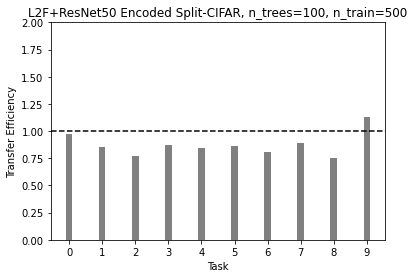

In [32]:
plot_te()

In [5]:
def plot_result():
    x = np.array([0, 1, 2, 3, 4, 5])
    
    cifar100_acc = pickle.load(open("output/cifar100_lf_acc_small.p", "rb"))
    unweighted_acc = pickle.load(open("output/unweighted_acc_small.p", "rb"))
    weighted_acc = pickle.load(open("output/weighted_acc_small.p", "rb"))
    task_aware_acc_mean = np.mean(pickle.load(open("output/task_aware_acc_small.p", "rb")))
    single_task_acc_mean = np.mean(pickle.load(open("output/single_task_acc_small.p", "rb")))
    negative_label_acc = 0.3712
    
    accs = [cifar100_acc, unweighted_acc, weighted_acc, negative_label_acc, task_aware_acc_mean, single_task_acc_mean]

    ax = plt.subplot(111)
    ax.bar(x, accs, width=0.2, color='k', align='center')
    
    ax.set_xticks(x)
    ax.set_xticklabels(['100 Class', 'Unweighted', 'Weighted', 'NOTA', 'Task Aware', 'Single Task'])
    
    ax.set_ylabel("Accuracy on CIFAR 100")
    ax.set_ylim(0, 1)
    
    ax.axhline(y=0.01, linestyle='--', color = 'k', label = 'Chance')
    ax.legend(loc = 'upper right')

    plt.savefig("cifar100_task_obl_fig.pdf", bbox_inches = "tight")
    plt.show()

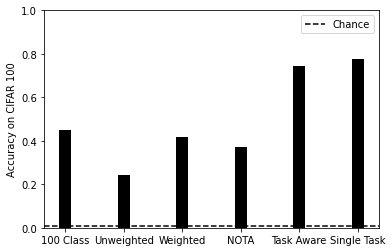

In [6]:
plot_result()